# TA Review 3
*2/27/2024*

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Jordan Sacks
* jordansacks@uchicago.edu

### Agenda
**Homework 2 Topics**
- Caps/Floors: Definitions, Uses, Notes
- Calculating Forward Volatilities from Flat Volatilites
- Calibrating the BDT Model
- Using the BDT Model to Price a Callable Bond
 <br>

### Libraries

In [17]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *
from bondmath import bootstrap_discounts_clean

# Caps & Floors

### What are they?

A ***cap*** creates a ceiling on a floating interest rate. If the market rates move above the cap rate, the buyer will receive the difference between the strike rate of the cap and the underlying index rate, acrrued over the corresponding period
- This option can only be exercised on specific settlement dates agreed between the buyer and the seller.
- A cap is actually a portfolio of **caplets**; a collection of sequentially maturing options with the same strike

A ***floor*** is the opposite of a cap. If market rates move below the floor rate, the buyer receives the difference between the floors strike and the underlying rate. 
- For example, Treasurers and Asset Managers can buy floors as a way of locking in a minimum rate of return on floating rate assets. 
- A floor is actually a portfolio of **floorlets**; a collection of sequentially maturing options with the same strike


### Uses
- **Hedging of Options Embedded in Assets/Liabilities**: It is common for insurance companies and pension funds to use caps/floors to hedge the risk arising from guaranteed payoff annuity products


- **Hedging Floating Rate Assets/Liabilities**: Debt managers can buy floors to protect against potential losses on outstanding fixed-rate debt when rates fall


- **Create Synthetic Positions**: Using caps and floors alone or in combination with other derivatives, investors can achieve a wide variety of payoff profiles


- **Enhance Returns**: Hedge funds frequently use caps/floors to express views on the level of interest rates at different points in time. By purchasing options, they have a limited downside (the paid premium) but a virtually unlimited upside. Also, sometimes funds sell caps/floors to enhance returns

### Market Quoting
- The market, generally, quotes caps/floors in terms of volatility. 
- The market convention is to quote using Black's formula (log-normal), however in recent times with the possibility of negative rates, markets have also started quoting volatility using the normal model (such as Bachelier)

### Important Notes
- Payoffs of the caps/floors is based on the interest rate observed the period before (i.e., payment in arrears). This impacts the design of the underlying rate tree and the payoffs determined from it. Specifically, the 1st node of our tree at T=1 is 0 because at initiation (T=0), we know the spot rate and thus the option is useless. 

### Process for Pricing 
Below we will go through these steps in more detail. I will assume we are working with caps but the process is the same for floors:
1. Download (or identify) feed of cap prices (note these prices are in terms of **flat volatility**). Data should consist of prices across tenors at the same strike (At-the-Money (ATM) quotes are the most liquid source of this info)
2. Strip the forward volatility from the quoted flat volatility.
3. Create a binomial tree representing the underlying rate
4. Use the tree to calculate the discounted payoffs at the different time steps and interest rate nodes
5. The first node is equal to the price

### 1. Get Data
Let's use the data from homework 2. Note that Mark already preprocessed the quotes into the cap_curves file but lets back-up a step and review what he did.

The file `data/cap_quotes_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR). Need this to build out discount curves and forward curves
* cap quotes. Need this to strip the flat volatilities and build forward volatilities


The file `data/cap_curves_2024-02-16.xlsx` is based on the data prep done on the quote file above. 
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

#### Start with Downloading SOFR Market Rates from Bloomberg (data provided by Mark)

In [18]:
### File Params
DATE = '2024-02-16'
FILEDATE = '2024-02-16'
FILEIN = f'../data/cap_quotes_{FILEDATE}'
BB_COMPOUND = 1 #compounding of quoted SOFR swaps
freqcap = 4
# can adjust frequency for binomial tree later, but keep quarterly to properly get caps

### SOFR Quotes
SHEET = 'sofr'
sofrdata_raw = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata_raw.columns = sofrdata_raw.loc['maturity'] 
sofrdata_raw.drop(index=['maturity'],inplace=True)
sofrdata_raw.index = pd.to_datetime(sofrdata_raw.index)

sofrdata_raw.columns.name ='maturity'
sofrdata_raw /= 100 # Convert from percentage to decimal

# Remove redudant columns from Bloomberg
sofrdata_raw = sofrdata_raw.T.drop_duplicates().T

In [19]:
sofrdata_raw.head()

maturity,0.246407,0.498289,0.750171,1.002053,1.245722,1.497604,1.749487,2.001369,2.245038,2.496920,...,3.000684,3.496235,4.000000,4.498289,5.002053,6.001369,7.000684,8.000000,9.002053,10.001369
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.000907,0.002000,0.003067,0.004060,0.004970,0.005920,0.006795,0.007629,0.008325,0.008910,...,0.009914,0.010610,0.011171,0.011550,0.012022,0.012636,0.013149,0.013568,0.013909,0.014237
2022-01-04,0.000908,0.001974,0.002981,0.003949,0.004875,0.005807,0.006670,0.007515,0.008215,0.008820,...,0.009822,0.010515,0.011107,0.011560,0.011996,0.012663,0.013227,0.013668,0.014028,0.014370
2022-01-05,0.000982,0.002180,0.003313,0.004400,0.005390,0.006395,0.007355,0.008203,0.008930,0.009525,...,0.010561,0.011245,0.011849,0.012295,0.012746,0.013410,0.013943,0.014348,0.014678,0.014994
2022-01-06,0.001117,0.002390,0.003569,0.004630,0.005655,0.006670,0.007650,0.008530,0.009270,0.009930,...,0.010961,0.011705,0.012288,0.012745,0.013161,0.013794,0.014286,0.014654,0.014946,0.015240
2022-01-07,0.001143,0.002373,0.003505,0.004584,0.005625,0.006660,0.007665,0.008598,0.009365,0.010090,...,0.011206,0.011925,0.012571,0.013020,0.013440,0.014133,0.014665,0.015058,0.015354,0.015647


#### Compounding

Bloomberg is quoting the swap rates per the swap frequency.

SOFR swaps are listed as annual frequency.

For convenience of our `freqcap` grid, convert this compounding.

In [20]:
sofrdata = sofrdata_raw.copy()
sofrdata = compound_rate(sofrdata,BB_COMPOUND,freqcap)
sofrdata.tail().style.format('{:.2%}')

maturity,0.2464065708418891,0.4982888432580425,0.7501711156741958,1.002053388090349,1.245722108145106,1.497604380561259,1.749486652977413,2.001368925393566,2.245037645448323,2.496919917864477,2.74880219028063,3.000684462696783,3.496235455167693,4.0,4.498288843258043,5.002053388090349,6.001368925393566,7.000684462696783,8.0,9.00205338809035,10.00136892539357
date,,,,,,,,,,,,,,,,,,,,,
2024-02-12 00:00:00,5.21%,5.10%,4.97%,4.82%,4.64%,4.49%,4.37%,4.27%,4.18%,4.11%,4.05%,4.01%,3.93%,3.89%,3.84%,3.82%,3.79%,3.77%,3.76%,3.76%,3.76%
2024-02-13 00:00:00,5.23%,5.17%,5.08%,4.96%,4.81%,4.67%,4.55%,4.47%,4.38%,4.31%,4.25%,4.21%,4.13%,4.08%,4.03%,4.00%,3.96%,3.93%,3.91%,3.90%,3.90%
2024-02-14 00:00:00,5.22%,5.15%,5.04%,4.91%,4.75%,4.60%,4.49%,4.40%,4.30%,4.23%,4.18%,4.14%,4.06%,4.01%,3.96%,3.93%,3.89%,3.87%,3.85%,3.85%,3.84%
2024-02-15 00:00:00,5.21%,5.14%,5.03%,4.91%,4.74%,4.60%,4.48%,4.38%,4.29%,4.22%,4.16%,4.12%,4.04%,3.99%,3.94%,3.91%,3.87%,3.84%,3.83%,3.82%,3.82%
2024-02-16 00:00:00,5.22%,5.16%,5.06%,4.94%,4.78%,4.64%,4.53%,4.43%,4.34%,4.27%,4.22%,4.18%,4.09%,4.04%,3.99%,3.96%,3.92%,3.89%,3.87%,3.87%,3.86%


#### Get Curves (Discount & Forward Curves)

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

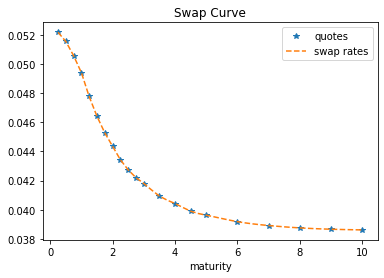

In [21]:
sofrcurves = interp_curves(sofrdata, dt = 1/freqcap, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

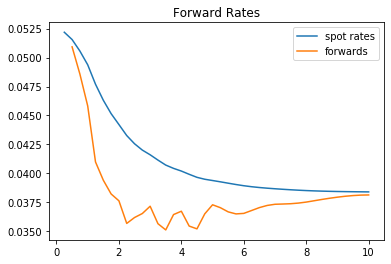

In [22]:
sofrcurves['spot rates'] = bootstrap_discounts_clean(sofrcurves[['swap rates']],compounding=4,key='swap rates')
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['spot rates'],n_compound=freqcap)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['spot rates'],n_compound=freqcap)
sofrcurves[['spot rates','forwards']].plot(title='Forward Rates');

In [23]:
sofrcurves.head()

,quotes,swap rates,spot rates,discounts,forwards
0.25,NaN,0.052190,0.052190,0.987121,NaN
0.50,NaN,0.051563,0.051559,0.974710,0.050928
0.75,NaN,0.050579,0.050564,0.963016,0.048575
1.00,NaN,0.049411,0.049378,0.952109,0.045823
1.25,NaN,0.047764,0.047698,0.942452,0.040985


#### Process the Cap quote data

In [24]:
# Import data
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

# Adjust the maturity frequency to nearest dt for better column headers as Bloomberg reports maturity as a precise decimal
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'
capdata = capdata.T.drop_duplicates().T
capdata.head()

maturity,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
date,,,,,,,,,,
2022-03-17,127.3,108.5,109.9,108.5,107.3,104.3,101.0,97.7,95.2,93.2
2022-03-18,96.2,104.9,108.0,108.5,108.0,105.0,101.8,98.3,95.4,93.4
2022-03-21,96.2,105.0,108.1,108.5,107.9,105.0,101.7,98.2,95.4,93.4
2022-03-22,75.1,108.3,115.2,115.3,113.6,109.9,106.3,102.8,99.9,97.5
2022-03-23,94.1,111.0,117.9,117.1,114.6,110.7,107.2,103.5,100.5,98.1


#### Adjust to Log-Normal Vols
Cap quotes in Bloomberg are downloaded in
* normal vol

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [25]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2
capquotes[DATE]

maturity
1.0     0.218665
2.0     0.331934
3.0     0.345800
4.0     0.346049
5.0     0.336056
6.0     0.336327
7.0     0.322801
8.0     0.315311
9.0     0.305981
10.0    0.298674
Name: 2024-02-16, dtype: float64

#### Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

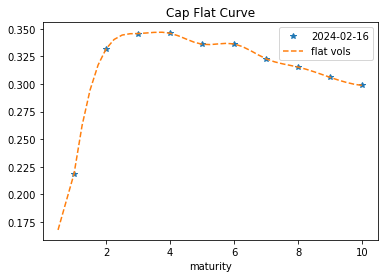

In [26]:
LIN_EXTRAP = True
FRONT_RATIO = .65

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/freqcap, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [27]:
capcurves.head()

,quotes,flat vols
0.25,NaN,NaN
0.50,NaN,0.167643
0.75,NaN,0.193154
1.00,0.218665,0.218665
1.25,NaN,0.262330


### 2. Strip Forward Volatility from Flat Volatility

`Flat To Forward Vol`

Inputs:
- flat volatilities at each tenor
- discount rates
- swap rates
- forward rates
- dt=.25 (default value)
- notional=100 (default value)

Ouputs:
- forward volatilities at each tenor

Steps (Imagine you are working sequentially through the caplets at t=0 -> T=T):
1. Calculate the cap price using the  `Cap Vol To Price` function
        Inputs:
        - flat volatilities
        - strike, 
        - forwards, 
        - discount rates, 
        - dt=.25
        - notional=100
        Outputs:
        - cap price
        Process:
        1. For each tenor, compute the cap price using Black's Formula
        2. Plug in the discount rate and forward rate at that T=t tenor
        3. Remember that the volatility is constant at the flat volatility value
        4. Total cap price is equal to the sum of prices found above
2. Calculate the most recent caplet price by subtracting the sum of previous caplet prices found prior
3. Create a wrapper function that plugs in different levels of volatility and returns a caplet price
4. Use a solver to identify the volatility that is used to price the caplet price

Generally, we have a list of cap quotes that have sequentially increasing tenors. For each quote, there is an associated flat volatility that applies to the entire timeframe. Our goal is to identify the forward volatility in between each tenor. To do this, we need to work forwards 1 time step at a time to find a volatility that prices the caplet during the same time period
        

In [28]:
# Add in the required inputs to the dataframe 
capcurves['discounts'] = sofrcurves["discounts"]
capcurves['swap rates'] = sofrcurves["swap rates"]
capcurves['forwards'] = sofrcurves["forwards"]

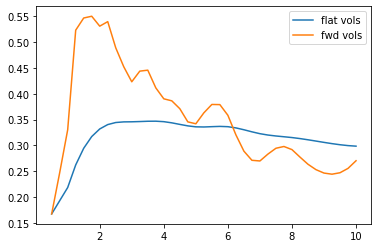

In [29]:
capcurves = flat_to_forward_vol(capcurves)

capcurves[['flat vols','fwd vols']].plot();

In [30]:
capcurves.head()

,flat vols,caplet prices,fwd vols,cap prices
0.25,NaN,NaN,NaN,NaN
0.50,0.167643,0.034466,0.167643,0.034466
0.75,0.193154,0.061220,0.247237,0.095686
1.00,0.218665,0.090638,0.330350,0.186325
1.25,0.262330,0.144760,0.522971,0.331084


### 3. Create Binomial Tree Using Black-Dermon-Toy (BDT) Model

#### Calibrate Theta
`Estimate Theta`

Inputs:
- forward volatilities
- discount factors
- dt=None (default value: Uses the difference between T=1 and T=0
- T=None (default value at T=T-1 which is the last value that needs to be calculated)

Ouputs:
- underlying rate tree
- theta

Steps (Imagine you are working sequentially through the caplets at t=0 -> T=T):
1. Create the rate tree template based on dt and T using the  `construct_rate_tree` function

For each time step in the tree:
2. If its the first time step then initialize the first node by converting the discount factor at T=0 into a rate
3. Use a wrapper function that plugs in different values of theta into `incremental_BDT_pricing` function
4. Use the wrapper function to identify the theta that returns a model price (discount factor) less the quoted price (current discount factor) of 0
5. Increment the tree using the newfound theta

`incremental_BDT_pricing` inputs:
- rate tree
- theta
- sigma
- dt = None

`incremental_BDT_pricing` process:
- Create a lambda function that uses the `payoff_bond` function. This function returns the discount factor associated with the bond and time to maturity (payoff assumes zero-coupon bond)
- Increment the size of the tree by 1 time step using the `incrementBDTtree` function which adds 2 additional nodes using the BDT formula below:
$$
\begin{align*}
z_{s,t+1} =& z_{s,t} + \theta_t\Delta_t + \sigma\sqrt{\Delta_t}\\
z_{s+1,t+1} =& z_{s,t} + \theta_t\Delta_t - \sigma\sqrt{\Delta_t}\\
\end{align*}
$$
- Returns the model price by discounting the cashflows of the new BDT tree increased by 1 time step


Generally, the process is: we input discount factors and forward volatilities. The code will sequentially move through time as T=0 -> T=T identifying the theta that allows the tree to increase by 1 time step by trying out many iterations of the BDT formula by changing theta to find the resulting discount factor that matches the quoted discount factor

In [31]:
# Prepare the inputs for the function
quotes = sofrcurves['discounts']*100
sigmas = capcurves['fwd vols']
# Assume the sigma is the same at T=0 as it is at T=1 since we dont have an initial caplet price from T=0 -> T=1
sigmas.iloc[0] = sigmas.iloc[1]

# Plug into function
theta, ratetree = estimate_theta(sigmas,quotes)
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75
theta,,-11.11%,-29.58%,-44.26%,-96.69%,-65.08%,-55.22%,-39.14%,-50.56%,-9.15%,-0.02%,11.80%,-13.35%,-1.57%,27.41%,20.99%,4.85%,19.26%,41.30%,35.61%,19.42%,13.79%,14.51%,19.68%,28.10%,33.12%,34.66%,32.79%,28.10%,24.76%,23.30%,23.78%,25.91%,27.67%,28.67%,28.90%,28.26%,26.65%,23.97%,20.07%


In [32]:
format_bintree(ratetree,style='{:.2%}')

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.19%,5.48%,5.76%,6.09%,6.21%,6.93%,7.95%,9.40%,10.85%,13.54%,16.98%,21.60%,26.09%,32.47%,42.71%,54.71%,67.18%,84.87%,111.85%,145.07%,182.59%,228.47%,286.34%,359.81%,453.11%,568.75%,710.37%,882.52%,1090.86%,1344.72%,1654.43%,2031.77%,2490.49%,3045.01%,3712.85%,4514.82%,5475.26%,6622.73%,7990.70%,9618.41%
1,,4.64%,4.87%,5.15%,5.25%,5.86%,6.72%,7.95%,9.18%,11.45%,14.36%,18.27%,22.06%,27.46%,36.12%,46.27%,56.81%,71.77%,94.59%,122.68%,154.41%,193.21%,242.15%,304.28%,383.17%,480.97%,600.73%,746.31%,922.49%,1137.17%,1399.08%,1718.18%,2106.09%,2575.03%,3139.79%,3817.98%,4630.18%,5600.54%,6757.37%,8133.86%
2,,,3.81%,4.02%,4.10%,4.58%,5.25%,6.21%,7.17%,8.94%,11.21%,14.27%,17.23%,21.44%,28.21%,36.13%,44.37%,56.05%,73.87%,95.80%,120.59%,150.89%,189.11%,237.63%,299.24%,375.62%,469.14%,582.83%,720.42%,888.08%,1092.62%,1341.82%,1644.76%,2010.98%,2452.04%,2981.67%,3615.97%,4373.77%,5277.21%,6352.18%
3,,,,2.89%,2.95%,3.29%,3.77%,4.46%,5.15%,6.43%,8.06%,10.25%,12.38%,15.41%,20.27%,25.97%,31.89%,40.28%,53.09%,68.85%,86.66%,108.44%,135.91%,170.77%,215.06%,269.94%,337.16%,418.87%,517.75%,638.24%,785.23%,964.33%,1182.05%,1445.24%,1762.21%,2142.84%,2598.70%,3143.31%,3792.58%,4565.14%
4,,,,,1.75%,1.95%,2.24%,2.64%,3.05%,3.81%,4.78%,6.08%,7.34%,9.13%,12.02%,15.39%,18.90%,23.88%,31.47%,40.81%,51.37%,64.28%,80.56%,101.23%,127.48%,160.01%,199.85%,248.29%,306.90%,378.32%,465.45%,571.61%,700.67%,856.68%,1044.56%,1270.19%,1540.39%,1863.22%,2248.08%,2706.02%
5,,,,,,1.13%,1.30%,1.53%,1.77%,2.21%,2.77%,3.52%,4.25%,5.29%,6.96%,8.91%,10.94%,13.82%,18.22%,23.63%,29.74%,37.21%,46.64%,58.61%,73.80%,92.64%,115.71%,143.75%,177.68%,219.03%,269.48%,330.94%,405.66%,495.98%,604.76%,735.38%,891.82%,1078.73%,1301.54%,1566.67%
6,,,,,,,0.75%,0.88%,1.02%,1.27%,1.60%,2.03%,2.45%,3.05%,4.01%,5.14%,6.31%,7.98%,10.51%,13.63%,17.16%,21.47%,26.91%,33.82%,42.58%,53.45%,66.76%,82.94%,102.52%,126.38%,155.49%,190.95%,234.06%,286.18%,348.94%,424.31%,514.58%,622.42%,750.98%,903.96%
7,,,,,,,,0.52%,0.60%,0.75%,0.94%,1.19%,1.44%,1.79%,2.36%,3.02%,3.71%,4.69%,6.18%,8.02%,10.09%,12.63%,15.83%,19.89%,25.05%,31.44%,39.27%,48.78%,60.30%,74.33%,91.45%,112.31%,137.67%,168.32%,205.23%,249.56%,302.65%,366.08%,441.70%,531.67%
8,,,,,,,,,0.35%,0.44%,0.55%,0.70%,0.84%,1.05%,1.38%,1.76%,2.17%,2.74%,3.60%,4.68%,5.88%,7.36%,9.23%,11.60%,14.60%,18.33%,22.89%,28.44%,35.16%,43.34%,53.32%,65.48%,80.27%,98.14%,119.66%,145.51%,176.46%,213.44%,257.53%,309.99%


### 4. Price a Callable Bond

#### Bond Parameters

In [33]:
FACE = 100
T=10
compound = 4
cpn = .06
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

MKTPRICE = 99.953

dt = 1/compound
tsteps = int(T/dt)

#### Create Cashflow Tree

In [34]:
cftree = construct_bond_cftree(T, compound, cpn)
cftree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
1,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
2,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
3,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
4,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0


#### Create lambda functions that calculate the payoff of the bond and the payoff of the option

In [40]:
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=FACE * (1+cpn/cpn_freq))
payoff_call = lambda p: np.maximum(p-STRIKE,0)

#### Calculate the Vanilla Bond Payoff Tree 
Inputs:
- payoff function
- rate tree
- cashflows from the bond

Process:
- Same process as lecture 1 where we discount the cashflows at each underlying rate

In [36]:
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
bondtree.style.format('{:.2f}',na_rep='')

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,117.36,112.58,104.29,98.41,89.03,82.09,71.88,64.51,54.23,47.13,37.60,31.71,23.76,19.60,13.51,11.27,7.10,6.35,3.47,3.66,1.68,2.26,0.76,1.37,0.28,0.75,0.07,0.33,0.01,0.10,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,125.20,117.99,113.19,104.81,98.74,89.17,82.15,71.85,64.32,53.91,46.75,37.18,31.13,23.00,18.79,12.76,10.43,6.24,5.52,2.85,3.05,1.23,1.75,0.46,0.97,0.14,0.47,0.03,0.18,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,129.33,125.68,118.50,113.65,105.23,99.23,89.74,82.72,72.46,65.02,54.69,47.44,37.68,31.56,23.43,18.98,12.73,10.29,6.15,5.33,2.65,2.74,1.01,1.45,0.33,0.75,0.08,0.33,0.01,0.10,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,135.45,129.40,125.80,118.68,114.01,105.82,100.00,90.73,84.02,74.06,66.76,56.43,49.30,39.67,33.37,24.94,20.32,14.00,11.31,6.90,5.76,2.92,2.82,1.07,1.39,0.34,0.67,0.08,0.28,0.01,0.08,0.00,0.01,0.00,0.00,0.00,0.00
4,,,,,137.46,134.92,128.99,125.61,118.77,114.38,106.51,101.13,92.34,86.01,76.33,69.44,59.54,52.55,42.87,36.64,28.28,23.48,16.76,13.61,8.73,7.20,3.98,3.60,1.59,1.78,0.54,0.86,0.14,0.38,0.03,0.13,0.00,0.03,0.00,0.12
5,,,,,,141.20,136.18,133.82,128.11,124.98,118.44,114.44,107.03,102.08,93.67,87.87,78.78,72.30,62.70,56.12,46.87,40.83,32.39,27.38,20.33,16.82,11.49,9.53,5.82,5.06,2.62,2.58,1.04,1.29,0.36,0.62,0.14,0.31,0.25,2.05
6,,,,,,,141.03,139.42,134.55,132.38,126.90,124.07,117.88,114.26,107.21,102.76,94.92,89.63,80.99,75.12,66.19,60.14,51.23,45.41,37.07,32.08,24.91,21.17,15.47,13.09,8.87,7.69,4.76,4.43,2.53,2.69,1.63,2.25,2.91,10.75
7,,,,,,,,143.17,138.90,137.41,132.70,130.74,125.52,122.96,117.06,113.83,107.25,103.24,95.87,91.18,83.26,78.05,69.69,64.18,55.76,50.39,42.42,37.69,30.63,26.89,21.04,18.49,14.02,12.67,9.60,9.41,7.91,9.54,12.38,27.26
8,,,,,,,,,141.81,140.80,136.63,135.29,130.75,128.98,123.96,121.68,116.13,113.25,107.05,103.55,96.79,92.72,85.41,80.83,73.14,68.32,60.60,55.91,48.53,44.34,37.72,34.41,28.95,26.89,23.01,22.66,21.19,24.19,29.28,47.45


### 5. Get Price

#### Convert from Dirty Price to Clean Price

We want to compare the (clean) strike to the **clean** bond price. Thus, we need to subtract accrued interest and coupons from the bond value tree.

$$P_{\text{clean}} = P_{\text{dirty}} - C_{\text{accrued int or coupon}}$$

Then, we will use this clean bond price tree as the underlying.

In [37]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

cleantree.style.format('{:.2f}',na_rep='')

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,117.36,111.08,104.29,96.91,89.03,80.59,71.88,63.01,54.23,45.63,37.60,30.21,23.76,18.10,13.51,9.77,7.10,4.85,3.47,2.16,1.68,0.76,0.76,0.00,0.28,0.00,0.07,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,123.70,117.99,111.69,104.81,97.24,89.17,80.65,71.85,62.82,53.91,45.25,37.18,29.63,23.00,17.29,12.76,8.93,6.24,4.02,2.85,1.55,1.23,0.25,0.46,0.00,0.14,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,129.33,124.18,118.50,112.15,105.23,97.73,89.74,81.22,72.46,63.52,54.69,45.94,37.68,30.06,23.43,17.48,12.73,8.79,6.15,3.83,2.65,1.24,1.01,0.00,0.33,0.00,0.08,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,133.95,129.40,124.30,118.68,112.51,105.82,98.50,90.73,82.52,74.06,65.26,56.43,47.80,39.67,31.87,24.94,18.82,14.00,9.81,6.90,4.26,2.92,1.32,1.07,0.00,0.34,0.00,0.08,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,137.46,133.42,128.99,124.11,118.77,112.88,106.51,99.63,92.34,84.51,76.33,67.94,59.54,51.05,42.87,35.14,28.28,21.98,16.76,12.11,8.73,5.70,3.98,2.10,1.59,0.28,0.54,0.00,0.14,0.00,0.03,0.00,0.00,0.00,0.00,0.00
5,,,,,,139.70,136.18,132.32,128.11,123.48,118.44,112.94,107.03,100.58,93.67,86.37,78.78,70.80,62.70,54.62,46.87,39.33,32.39,25.88,20.33,15.32,11.49,8.03,5.82,3.56,2.62,1.08,1.04,0.00,0.36,0.00,0.14,0.00,0.25,0.55
6,,,,,,,141.03,137.92,134.55,130.88,126.90,122.57,117.88,112.76,107.21,101.26,94.92,88.13,80.99,73.62,66.19,58.64,51.23,43.91,37.07,30.58,24.91,19.67,15.47,11.59,8.87,6.19,4.76,2.93,2.53,1.19,1.63,0.75,2.91,9.25
7,,,,,,,,141.67,138.90,135.91,132.70,129.24,125.52,121.46,117.06,112.33,107.25,101.74,95.87,89.68,83.26,76.55,69.69,62.68,55.76,48.89,42.42,36.19,30.63,25.39,21.04,16.99,14.02,11.17,9.60,7.91,7.91,8.04,12.38,25.76
8,,,,,,,,,141.81,139.30,136.63,133.79,130.75,127.48,123.96,120.18,116.13,111.75,107.05,102.05,96.79,91.22,85.41,79.33,73.14,66.82,60.60,54.41,48.53,42.84,37.72,32.91,28.95,25.39,23.01,21.16,21.19,22.69,29.28,45.95


#### Calculate the Callable Portion of the Bond

This is where we introduce the payoff function of the call

In [41]:
if CLEANCALL:
    undertree = cleantree
else:
    undertree = bondtree
    
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= undertree, style='american')
format_bintree(calltree)

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.0,7.25,7.5,7.75,8.0,8.25,8.5,8.75,9.0,9.25,9.5,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19.56,15.49,11.89,8.80,6.29,4.33,2.85,1.80,1.09,0.62,0.33,0.17,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,24.14,19.52,15.33,11.59,8.46,5.95,4.02,2.60,1.61,0.95,0.53,0.27,0.13,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,29.33,24.19,19.46,15.03,11.21,8.08,5.59,3.72,2.37,1.44,0.83,0.45,0.23,0.10,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,33.95,29.40,24.30,19.19,14.63,10.83,7.67,5.23,3.43,2.15,1.28,0.72,0.38,0.19,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,37.46,33.42,28.99,24.11,18.77,14.26,10.36,7.24,4.89,3.16,1.94,1.13,0.62,0.32,0.15,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,39.70,36.18,32.32,28.11,23.48,18.44,13.73,9.82,6.80,4.53,2.87,1.73,0.99,0.53,0.26,0.12,0.05,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,41.03,37.92,34.55,30.88,26.90,22.57,17.88,13.05,9.24,6.34,4.14,2.58,1.52,0.84,0.44,0.20,0.09,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,41.67,38.90,35.91,32.70,29.24,25.52,21.46,17.06,12.33,8.71,5.84,3.74,2.28,1.31,0.70,0.35,0.15,0.06,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,41.81,39.30,36.63,33.79,30.75,27.48,23.96,20.18,16.13,11.75,8.08,5.31,3.33,1.99,1.11,0.57,0.26,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Calculate final price and compare to market quote

In [42]:
QUOTE_CALLABLE_CLEAN = MKTPRICE
num_accrued = int((T*compound) %cpn_freq)
quote_callable_dirty = QUOTE_CALLABLE_CLEAN + num_accrued * (cpn/compound)*FACE

callablebondtree = bondtree - calltree
model_price_dirty = callablebondtree.iloc[0,0]
model_price_clean = model_price_dirty - accint.iloc[0]

prices = pd.DataFrame({'clean':[QUOTE_CALLABLE_CLEAN, model_price_clean], 'dirty':[quote_callable_dirty, model_price_dirty]}, index=['market quote','model'])
prices.style.format('{:.2f}')

,clean,dirty
market quote,99.95,99.95
model,97.80,97.80
